In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add, BatchNormalization, Activation
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import json
# import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
from keras import backend as K
from keras.utils import to_categorical
# from focal_loss import sparse_categorical_focal_loss
# from focal_loss import SparseCategoricalFocalLoss
# from tensorflow.keras.metrics import DiceCoefficient

In [ ]:
# Correct recall for tf
def recall_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(Y_true * Y_pred)
    possible_positives = tf.reduce_sum(Y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [ ]:
# Correct tf precision
def precision_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_true * Y_pred, 0, 1)))
    print(true_positives)
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_pred, 0, 1)))
    print(predicted_positives)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [ ]:
# Correct tf dicecoefficient
def dice_coefficient_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    smooth = 1e-5

    intersection = tf.reduce_sum(Y_true * Y_pred)
    union = tf.reduce_sum(Y_true) + tf.reduce_sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [ ]:
# Pre-Processing the training data
n_classes = 3
X_train = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/train2/X_train128.npy')
Y_train = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/train2/Y_train128.npy')

X_test = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/X_test128.npy')
Y_test = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/Y_test128.npy')

X_train = np.expand_dims(X_train, axis = 3)
#Normalizing X_train values only
X_train = normalize(X_train, axis = 1)

X_test = np.expand_dims(X_test, axis = 3)
X_test = normalize(X_test, axis = 1)


Y_train = np.expand_dims(Y_train, axis = 3)
Y_test = np.expand_dims(Y_test, axis = 3)

print("Training Data")
print(X_train.shape)
print(np.unique(X_train))

print(Y_train.shape)
print(np.unique(Y_train))

# Connverting the Y_train into categorical
Y_train_cat = to_categorical(Y_train, num_classes=n_classes)
Y_train_cat = Y_train_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))
print(Y_train_cat.shape)

Y_test_cat = to_categorical(Y_test, num_classes=n_classes)
Y_test_cat = Y_test_cat.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], n_classes))
print(Y_test_cat.shape)

Training Data
(10000, 128, 128, 1)
[0.00000000e+00 5.22079475e-04 5.32547051e-04 ... 9.99986437e-01
 9.99988443e-01 1.00000000e+00]
(10000, 128, 128, 1)
[0 1 2]
(10000, 128, 128, 3)
(1916, 128, 128, 3)


In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
n_classes = 3  # 0, 1, 2
#Model Building
seed = 42
np.random.seed = seed
# 1) Creating the input layer. The input layer are the images of 128*128 size and channel = 1
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = inputs

# BLOCK 1
c1 = Conv2D(16, (3,3), strides= (1, 1), padding='same')(s)
c1 =  Activation('relu')(c1)
c1 = Conv2D(16, (3,3), strides= (1, 1), padding='same')(c1)
c1 = BatchNormalization()(c1)
c1 =  Activation('relu')(c1)    #-->


#Jump Connection
conn1 = Activation('relu')(c1) #--->

pool1 = Conv2D(filters = 16 ,  # Set the desired number of filters
               kernel_size=(5, 5),
               padding='same',  # Padding of 2 is achieved with 'valid' padding
               strides=(1, 1))(conn1)
x1 = Activation('relu')(pool1)
x1 = Conv2D(16, (3,3), strides= (1, 1), padding='same')(x1) #-->

sum1 = Add()([conn1, x1])

pool2 = Conv2D(filters = 16 ,  # Set the desired number of filters
               kernel_size=(5, 5),
               padding='same',  # Padding of 2 is achieved with 'valid' padding
               strides=(1, 1))(x1)
x2 = Activation('relu')(pool2)
x2 = Conv2D(16, (3,3), strides= (1, 1), padding='same')(x2) #-->

sum2 = Add()([sum1, x2]) #->
#---------------------------------------------------------------------------------------------#

#2nd Block
c2 = Conv2D(32, (3,3), strides= (1, 1), padding='same')(c1)
c2 =  Activation('relu')(c2)
c2 = Conv2D(32, (3,3), strides= (1, 1), padding='same')(c2)
c2 = BatchNormalization()(c2)
c2 =  Activation('relu')(c2) #-->

#Jump Connection
conn2 = Activation('relu')(c2) #--->

pool3 = Conv2D(filters = 32 ,  # Set the desired number of filters
               kernel_size=(5, 5),
               padding='same',  # Padding of 2 is achieved with 'valid' padding
               strides=(1, 1))(conn2)
x3 = Activation('relu')(pool3)
x3 = Conv2D(32, (3,3), strides= (1, 1), padding='same')(x3) #-->

sum3 = Add()([conn2, x3])

pool4 = Conv2D(filters = 32 ,  # Set the desired number of filters
               kernel_size=(5, 5),
               padding='same',  # Padding of 2 is achieved with 'valid' padding
               strides=(1, 1))(x3)
x4 = Activation('relu')(pool4)
x4 = Conv2D(32, (3,3), strides= (1, 1), padding='same')(x4) #-->

sum4 = Add()([sum3, x4]) #->
#----------------------------------------------------------------------------------------------------#

#3rd Block
c3 = Conv2D(64, (3,3), strides= (1, 1), padding='same')(c2)
c3 =  Activation('relu')(c3)
c3 = Conv2D(64, (3,3), strides= (1, 1), padding='same')(c3)
c3 = BatchNormalization()(c3)
c3 =  Activation('relu')(c3) #-->


conn3 = Activation('relu')(c3) #--->

pool5 = Conv2D(filters = 64 ,  # Set the desired number of filters
               kernel_size=(5, 5),
               padding='same',  # Padding of 2 is achieved with 'valid' padding
               strides=(1, 1))(conn3)
x5 = Activation('relu')(pool5)
x5 = Conv2D(64, (3,3), strides= (1, 1), padding='same')(x5) #-->

sum5 = Add()([conn3, x5])

pool6 = Conv2D(filters = 64 ,  # Set the desired number of filters
               kernel_size=(5, 5),
               padding='same',  # Padding of 2 is achieved with 'valid' padding
               strides=(1, 1))(x5)
x6 = Activation('relu')(pool6)
x6 = Conv2D(64, (3,3), strides= (1, 1), padding='same')(x6) #-->

sum6 = Add()([sum5, x6]) #->

#----------------------------------------------------------------------------------------------------#

#4th Block
c4 = Conv2D(128, (3,3), strides= (1, 1), padding='same')(c3)
c4 =  Activation('relu')(c4)
c4 = Conv2D(128, (3,3), strides= (1, 1), padding='same')(c4)
c4 = BatchNormalization()(c4)
c4 =  Activation('relu')(c4) #-->


conn4 = Activation('relu')(c4) #--->
pool7 = Conv2D(filters = 128 ,  # Set the desired number of filters
               kernel_size=(5, 5),
               padding='same',  # Padding of 2 is achieved with 'valid' padding
               strides=(1, 1))(conn4)
x7 = Activation('relu')(pool7)
x7 = Conv2D(128, (3,3), strides= (1, 1), padding='same')(x7) #-->

sum7 = Add()([conn4, x7])

pool8 = Conv2D(filters = 128 ,  # Set the desired number of filters
               kernel_size=(5, 5),
               padding='same',  # Padding of 2 is achieved with 'valid' padding
               strides=(1, 1))(x7)
x8 = Activation('relu')(pool8)
x8 = Conv2D(128, (3,3), strides= (1, 1), padding='same')(x8) #-->

sum8 = Add()([sum7, x8]) #->

#----------------------------------------------------------------------------------------------------#

#5th Block
c5 = Conv2D(256, (3,3), strides= (1, 1), padding='same')(c4)
c5 =  Activation('relu')(c5)
c5 = Conv2D(256, (3,3), strides= (1, 1), padding='same')(c5)
c5 = BatchNormalization()(c5)
c5 =  Activation('relu')(c5) #-->


p1 = tf.keras.layers.MaxPooling2D(2,2)(c5)
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(p1)
u6 = tf.keras.layers.concatenate([u6, sum8])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(u6)
c6 = tf. keras.layers.Dropout (0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)


p2 = tf.keras.layers.MaxPooling2D(2,2)(c6)
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(p2)
u7 = tf.keras. layers. concatenate ([u7, sum6])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf. keras.layers.Dropout (0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

p3 = tf.keras.layers.MaxPooling2D(2,2)(c7)
u8 = tf. keras.layers .Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(p3)
u8 = tf. keras.layers. concatenate ([u8, sum4])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout (0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

p4 = tf.keras.layers.MaxPooling2D(2,2)(c8)
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(p4)
u9 = tf.keras.layers. concatenate ([u9, sum2], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf. keras.layers. Dropout (0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)



outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation= 'softmax')(c9)

model = tf.keras.Model(inputs= [inputs], outputs= [outputs])
model.summary()

model.compile(
    optimizer=Adam(learning_rate),
    loss= 'categorical_crossentropy',
    metrics=[
        BinaryAccuracy(name='accuracy'),  # Binary Accuracy
        MeanIoU(num_classes=3, name='iou'),  # Intersection Over Union (IoU)
        recall_tf,  # Sensitivity
        precision_tf,
         tf.keras.metrics.BinaryIoU(
            threshold=0.5,
            name='binaryIoU',
            dtype=None
        ),
        Recall(name='recall_inbuilt'),
        Precision(name='precision_inbuilt'),
        dice_coefficient_tf  # Custom dice coefficient function
    ]
)

checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project7thSem/Liver/NewArch/Categorical/liver_checkpoint.h5', verbose=1, save_best_only=True)


callbacks = [
              tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir = '/content/drive/MyDrive/Project7thSem/Liver/NewArch/Categorical'),
              checkpointer
]

# Saving the accuracy as the model gets trained

results = model.fit(X_train, Y_train_cat, validation_split=0.1, batch_size=16, epochs=100,  callbacks=callbacks)
model.save('/content/drive/MyDrive/Project7thSem/Liver/NewArch/Categorical/unet_liver_model128.h5')


# Saving the data
with open('/content/drive/MyDrive/Project7thSem/Liver/NewArch/Categorical/training_history128.json', 'w') as file:
     json.dump(results.history, file)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_2[0][0]']             
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['activation[0][0]']          
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


563/563 [==============================] - 616s 1s/step - loss: 0.0778 - accuracy: 0.9812 - iou: 0.4757 - recall_tf: 0.9686 - precision_tf: 0.9736 - binaryIoU: 0.9587 - recall_inbuilt: 0.9685 - precision_inbuilt: 0.9750 - dice_coefficient_tf: 0.9709 - val_loss: 0.0901 - val_accuracy: 0.9848 - val_iou: 0.3333 - val_recall_tf: 0.9658 - val_precision_tf: 0.9882 - val_binaryIoU: 0.9663 - val_recall_inbuilt: 0.9659 - val_precision_inbuilt: 0.9882 - val_dice_coefficient_tf: 0.9769
Epoch 2/100
563/563 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9898 - iou: 0.5245 - recall_tf: 0.9834 - precision_tf: 0.9860 - binaryIoU: 0.9774 - recall_inbuilt: 0.9834 - precision_inbuilt: 0.9860 - dice_coefficient_tf: 0.9847
Epoch 2: val_loss did not improve from 0.09010
563/563 [==============================] - 556s 987ms/step - loss: 0.0439 - accuracy: 0.9898 - iou: 0.5245 - recall_tf: 0.9834 - precision_tf: 0.9860 - binaryIoU: 0.9774 - recall_inbuilt: 0.9834 - precision_inbuilt: 

In [ ]:


def convolution_block(x, filters, kernel_size=(3, 3), strides=(1, 1)):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(input_tensor, filters):
    x = convolution_block(input_tensor, filters)
    x = convolution_block(x, filters)
    return Add()([input_tensor, x])

def build_model(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)

    # Encoding path
    encoding_stages = []
    x = inputs
    for filters in [64, 128, 256, 256, 256]:
        for _ in range(2):  # Two convolution blocks per stage
            x = convolution_block(x, filters)
        encoding_stages.append(x)
        x = residual_block(x, filters)

    # Decoding path
    for i, filters in enumerate([256, 128, 64, 32]):
        x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Add()([x, encoding_stages[i]])  # Skip connection

    # Final convolution layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Example input shape for 2D images
input_shape_2d = (128, 128, 1)

# Create the model
model_2d = build_model(input_shape=input_shape_2d)
model_2d.summary()


In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss/unet_liver_model128.h5',custom_objects={'recall_tf': recall_tf, 'precision_tf': precision_tf, 'dice_coefficient_tf': dice_coefficient_tf})
results = model.evaluate(X_test, Y_test_cat)

60/60 [==============================] - 49s 636ms/step - loss: 0.0428 - accuracy: 0.9935 - iou: 0.3362 - recall_tf: 0.9895 - precision_tf: 0.9908 - binaryIoU: 0.9854 - recall_inbuilt: 0.9895 - precision_inbuilt: 0.9908 - dice_coefficient_tf: 0.9902


In [ ]:
labels = ['loss', 'accuracy', 'iou', 'recall', 'precision', 'binaryIoU', 'recall_inbuilt', 'precision_inbuilt', 'dice_coefficient_tf']
results_dict = dict(zip(labels, results))

with open('/content/drive/MyDrive/Project7thSem/Liver/Unet/FocalLoss/Graph/testing_results_final.json', 'w') as json_file:
    json.dump(results_dict, json_file)

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_argmax = np.argmax(Y_pred, axis=3)

60/60 [==============================] - 27s 442ms/step


In [ ]:
from keras.metrics import MeanIoU

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(Y_test[:,:,:,0], Y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.79647946


In [ ]:
# To calculate IoU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0, 0] / (values[0, 0] + values[0, 1] + values[0, 2] + values[1, 0] + values[2, 0])
class2_IoU = values[1, 1] / (values[1, 1] + values[1, 0] + values[1, 2] + values[0, 1] + values[2, 1])
class3_IoU = values[2, 2] / (values[2, 2] + values[2, 0] + values[2, 1] + values[0, 2] + values[1, 2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


[[1.6777216e+07 1.2572400e+05 1.2108000e+04]
 [1.1618800e+05 1.8835550e+06 2.3459000e+04]
 [6.5690000e+03 2.4655000e+04 7.7830000e+04]]
IoU for class1 is:  0.9847053
IoU for class2 is:  0.8665677
IoU for class3 is:  0.5381653


In [ ]:
prediction = (model.predict(X_test))

60/60 [==============================] - 27s 446ms/step


In [ ]:
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

In [ ]:

num_images = len(X_test)

# Set up subplots
fig, axes = plt.subplots(100, 3, figsize=(15, 5*100))

for i in range(100):
    # Plot original image
    axes[i, 0].imshow(X_test[i], cmap= 'gray')
    axes[i, 0].set_title('Original Image')

    # Plot ground truth mask
    ground_truth= Y_test[i]
    axes[i, 1].imshow(ground_truth[:,:,0], cmap='jet')
    axes[i, 1].set_title('Ground Truth Mask')

    # # Plot predicted mask
    axes[i, 2].imshow(predicted_img[i], cmap='gray')
    axes[i, 2].set_title('Predicted Mask')


# Adjust layout
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 21ms/step


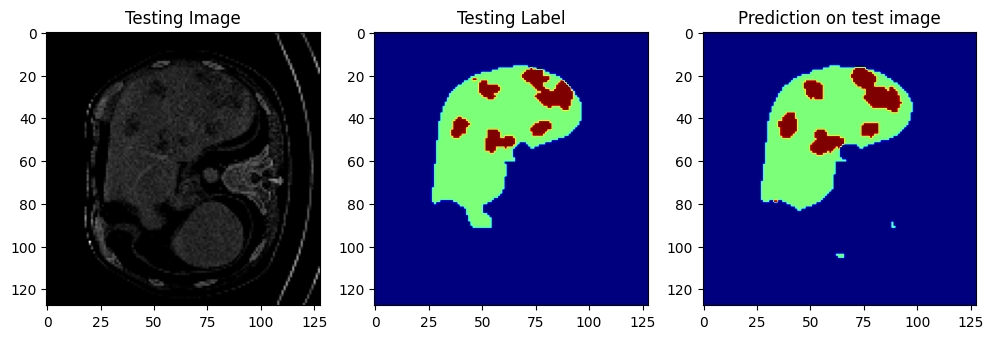

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()